In [1]:
import pyspark
import pyspark.sql  as pyspark_sql
import pyspark.sql.types as pyspark_types
import pyspark.sql.functions  as pyspark_functions
from pyspark import SparkContext, SparkConf
from pyspark.sql.functions import col, to_date, sum as sum_
from pyspark.sql.window import Window
from pyspark.sql.functions import coalesce, col, lag, lead, count
from pyspark.sql.functions import mean
from pyspark.sql.functions import when
import plotly.express as px

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

In [2]:
# create the session
conf = SparkConf().set("spark.ui.port", "4050")

# create the context
sc = pyspark.SparkContext(conf=conf)
spark = pyspark_sql.SparkSession.builder.getOrCreate()

In [3]:
# Load the dataset
pt_data = spark.read.csv("dataset/Precipitation_Avg-temperature.csv", header=True)

In [4]:
pt_data.printSchema()

root
 |-- STATION: string (nullable = true)
 |-- NAME: string (nullable = true)
 |-- LATITUDE: string (nullable = true)
 |-- LONGITUDE: string (nullable = true)
 |-- ELEVATION: string (nullable = true)
 |-- DATE: string (nullable = true)
 |-- PRCP: string (nullable = true)
 |-- TAVG: string (nullable = true)
 |-- TMAX: string (nullable = true)
 |-- TMIN: string (nullable = true)



In [10]:
pt_data.show()

+-----------+----------------+--------+---------+---------+----------+----+----+----+----+
|    STATION|            NAME|LATITUDE|LONGITUDE|ELEVATION|      DATE|PRCP|TAVG|TMAX|TMIN|
+-----------+----------------+--------+---------+---------+----------+----+----+----+----+
|CEM00043418|   CHINA BAY, CE|   8.539|   81.182|      1.8|2019-01-01|   0|  79|  82|  76|
|CEM00043466|     COLOMBO, CE|     6.9|   79.867|      7.0|2019-01-01|   0|  81|  89|  74|
|CE000434730|NUWARA ELIYA, CE|   6.967|   80.767|   1880.0|2019-01-01|   0|  61|  71|  49|
|CEM00043424|    PUTTALAM, CE|   8.033|   79.833|      2.0|2019-01-01|   0|  78|  87|NULL|
|CEM00043441|  KURUNEGALA, CE|   7.467|   80.367|    116.0|2019-01-02|   0|  78|NULL|  72|
|CEM00043418|   CHINA BAY, CE|   8.539|   81.182|      1.8|2019-01-02|   0|  78|NULL|  76|
|CEM00043466|     COLOMBO, CE|     6.9|   79.867|      7.0|2019-01-02|   0|  78|NULL|  74|
|CE000434730|NUWARA ELIYA, CE|   6.967|   80.767|   1880.0|2019-01-02|   0|  59|NULL|  49|

In [11]:
# Convert the columns to integer type
pt_data = pt_data.withColumn("PRCP", col("PRCP").cast("integer")) \
       .withColumn("TAVG", col("TAVG").cast("integer")) \
       .withColumn("TMAX", col("TMAX").cast("integer")) \
       .withColumn("TMIN", col("TMIN").cast("integer"))
pt_data = pt_data.withColumn("DATE", to_date(col("DATE"), 'yyyy-MM-dd'))

# Show the updated DataFrame schema to confirm the changes
pt_data.printSchema()
pt_data.show(5)

root
 |-- STATION: string (nullable = true)
 |-- NAME: string (nullable = true)
 |-- LATITUDE: string (nullable = true)
 |-- LONGITUDE: string (nullable = true)
 |-- ELEVATION: string (nullable = true)
 |-- DATE: date (nullable = true)
 |-- PRCP: integer (nullable = true)
 |-- TAVG: integer (nullable = true)
 |-- TMAX: integer (nullable = true)
 |-- TMIN: integer (nullable = true)

+-----------+----------------+--------+---------+---------+----------+----+----+----+----+
|    STATION|            NAME|LATITUDE|LONGITUDE|ELEVATION|      DATE|PRCP|TAVG|TMAX|TMIN|
+-----------+----------------+--------+---------+---------+----------+----+----+----+----+
|CEM00043418|   CHINA BAY, CE|   8.539|   81.182|      1.8|2019-01-01|   0|  79|  82|  76|
|CEM00043466|     COLOMBO, CE|     6.9|   79.867|      7.0|2019-01-01|   0|  81|  89|  74|
|CE000434730|NUWARA ELIYA, CE|   6.967|   80.767|   1880.0|2019-01-01|   0|  61|  71|  49|
|CEM00043424|    PUTTALAM, CE|   8.033|   79.833|      2.0|2019-01-01

In [12]:
unique_locations_count = pt_data.select("NAME").distinct().count()
print(f"Number of unique values in the 'NAME' column: {unique_locations_count}")
pt_data.select("NAME").distinct().show()

Number of unique values in the 'NAME' column: 5
+----------------+
|            NAME|
+----------------+
|  KURUNEGALA, CE|
|    PUTTALAM, CE|
|     COLOMBO, CE|
|NUWARA ELIYA, CE|
|   CHINA BAY, CE|
+----------------+



### DATA PREPROCESSING

In [13]:
# Checking the sum of the Null values
pt_data.select(*[sum_(col(c).isNull().cast("int")).alias(c) for c in pt_data.columns]).show()

+-------+----+--------+---------+---------+----+----+----+----+----+
|STATION|NAME|LATITUDE|LONGITUDE|ELEVATION|DATE|PRCP|TAVG|TMAX|TMIN|
+-------+----+--------+---------+---------+----+----+----+----+----+
|      0|   0|       0|        0|        0|   0|   0|   0| 959|1646|
+-------+----+--------+---------+---------+----+----+----+----+----+



In [14]:
# Initialize a counter for null values
null_count = pt_data.filter(col("PRCP").isNull()).count()

# Continue the process until there are no nulls left
while null_count > 0:
    # Define the window specifications
    backward_windowSpec = Window.orderBy("DATE")
    forward_windowSpec = Window.orderBy("DATE")
    
    # Use lag to carry the last observation forward
    previous_value = lag("PRCP", 1).over(backward_windowSpec)
    pt_data = pt_data.withColumn("PRCP", coalesce("PRCP", previous_value))
    
    # Use lead to carry the next observation backward
    next_value = lead("PRCP", 1).over(forward_windowSpec)
    pt_data = pt_data.withColumn("PRCP", coalesce("PRCP", next_value))
    
    # Update the null count
    null_count = pt_data.filter(col("PRCP").isNull()).count()

In [15]:
# Initialize a counter for null values
null_count = pt_data.filter(col("TMAX").isNull()).count()

# Continue the process until there are no nulls left
while null_count > 0:
    # Define the window specifications
    backward_windowSpec = Window.orderBy("DATE")
    forward_windowSpec = Window.orderBy("DATE")
    
    # Use lag to carry the last observation forward
    previous_value = lag("TMAX", 1).over(backward_windowSpec)
    pt_data = pt_data.withColumn("TMAX", coalesce("TMAX", previous_value))
    
    # Use lead to carry the next observation backward
    next_value = lead("TMAX", 1).over(forward_windowSpec)
    pt_data = pt_data.withColumn("TMAX", coalesce("TMAX", next_value))
    
    # Update the null count
    null_count = pt_data.filter(col("TMAX").isNull()).count()

In [16]:
# Initialize a counter for null values
null_count = pt_data.filter(col("TMIN").isNull()).count()

# Continue the process until there are no nulls left
while null_count > 0:
    # Define the window specifications
    backward_windowSpec = Window.orderBy("DATE")
    forward_windowSpec = Window.orderBy("DATE")
    
    # Use lag to carry the last observation forward
    previous_value = lag("TMIN", 1).over(backward_windowSpec)
    pt_data = pt_data.withColumn("TMIN", coalesce("TMIN", previous_value))
    
    # Use lead to carry the next observation backward
    next_value = lead("TMIN", 1).over(forward_windowSpec)
    pt_data = pt_data.withColumn("TMIN", coalesce("TMIN", next_value))
    
    # Update the null count
    null_count = pt_data.filter(col("TMIN").isNull()).count()

In [17]:
# Checking the sum of the Null values
pt_data.select(*[sum_(col(c).isNull().cast("int")).alias(c) for c in pt_data.columns]).show()

+-------+----+--------+---------+---------+----+----+----+----+----+
|STATION|NAME|LATITUDE|LONGITUDE|ELEVATION|DATE|PRCP|TAVG|TMAX|TMIN|
+-------+----+--------+---------+---------+----+----+----+----+----+
|      0|   0|       0|        0|        0|   0|   0|   0|   0|   0|
+-------+----+--------+---------+---------+----+----+----+----+----+



In [18]:
dataset_length = pt_data.count()
print("The length of the dataset is:", dataset_length)

The length of the dataset is: 8745


In [19]:
pt_data = pt_data.dropDuplicates()
dataset_length = pt_data.count()
print("The length of the dataset after dropping dupplicates is:", dataset_length)

The length of the dataset after dropping dupplicates is: 8745


In [20]:
# Convert the PySpark DataFrame to a Pandas DataFrame
pt_data = pt_data.toPandas()
pt_data

,STATION,NAME,LATITUDE,LONGITUDE,ELEVATION,DATE,PRCP,TAVG,TMAX,TMIN
0,CEM00043418,"CHINA BAY, CE",8.539,81.182,1.8,2019-01-01,0,79,82,76
1,CEM00043466,"COLOMBO, CE",6.9,79.867,7.0,2019-01-01,0,81,89,74
2,CE000434730,"NUWARA ELIYA, CE",6.967,80.767,1880.0,2019-01-01,0,61,71,49
3,CEM00043424,"PUTTALAM, CE",8.033,79.833,2.0,2019-01-01,0,78,87,49
4,CEM00043441,"KURUNEGALA, CE",7.467,80.367,116.0,2019-01-02,0,78,87,72
...,...,...,...,...,...,...,...,...,...,...
8740,CEM00043441,"KURUNEGALA, CE",7.467,80.367,116.0,2023-12-31,0,79,87,75
8741,CEM00043418,"CHINA BAY, CE",8.539,81.182,1.8,2023-12-31,0,82,85,76
8742,CEM00043466,"COLOMBO, CE",6.9,79.867,7.0,2023-12-31,0,81,85,75
8743,CE000434730,"NUWARA ELIYA, CE",6.967,80.767,1880.0,2023-12-31,0,60,90,57


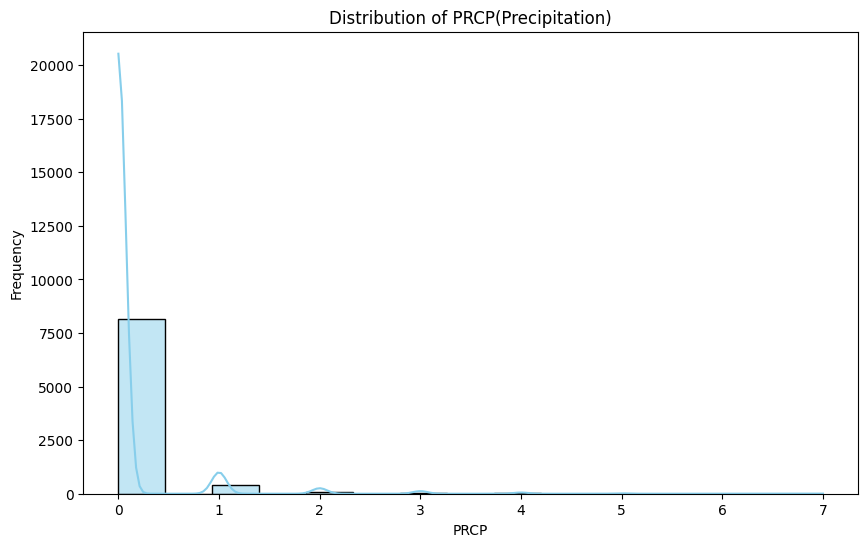

In [21]:
# Plot the distribution of the "HCHO Reading" column
plt.figure(figsize=(10, 6))
sns.histplot(pt_data["PRCP"], kde=True, color='skyblue')
plt.title('Distribution of PRCP(Precipitation)')
plt.xlabel('PRCP')
plt.ylabel('Frequency')
plt.show()

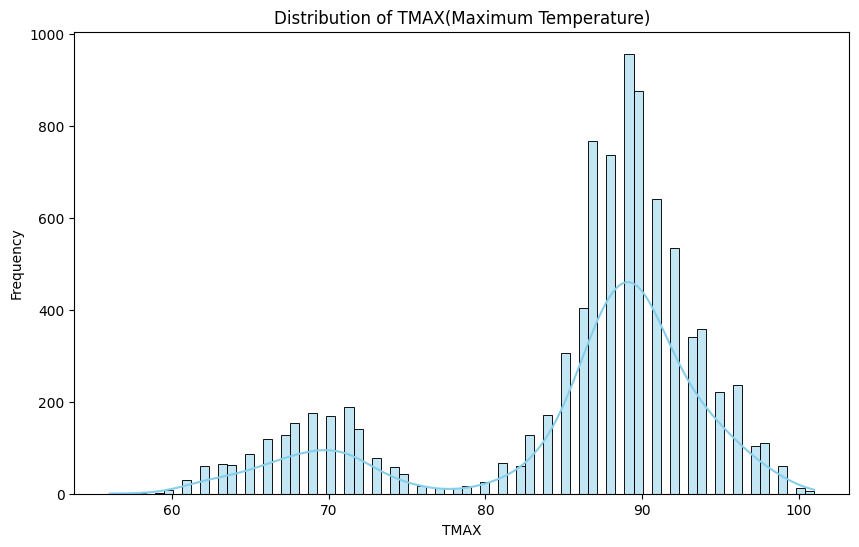

In [22]:
# Plot the distribution of the "HCHO Reading" column
plt.figure(figsize=(10, 6))
sns.histplot(pt_data["TMAX"], kde=True, color='skyblue')
plt.title('Distribution of TMAX(Maximum Temperature)')
plt.xlabel('TMAX')
plt.ylabel('Frequency')
plt.show()

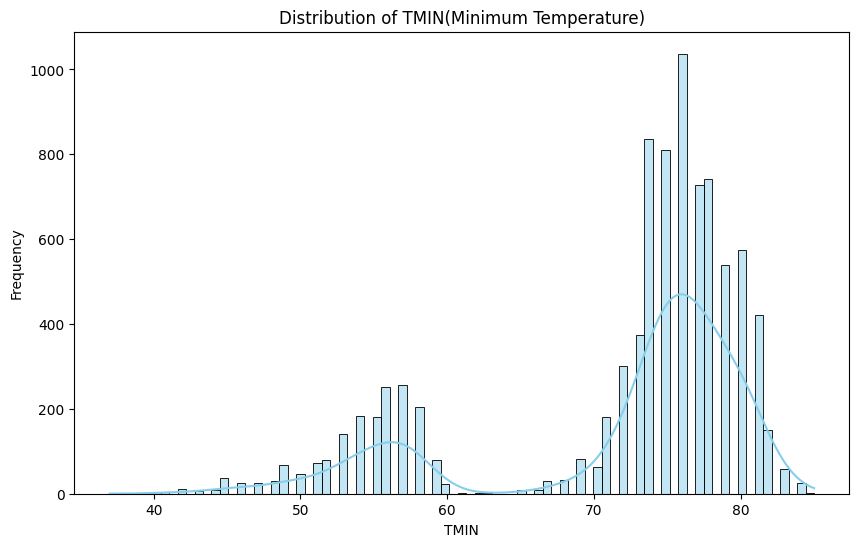

In [23]:
# Plot the distribution of the "HCHO Reading" column
plt.figure(figsize=(10, 6))
sns.histplot(pt_data["TMIN"], kde=True, color='skyblue')
plt.title('Distribution of TMIN(Minimum Temperature)')
plt.xlabel('TMIN')
plt.ylabel('Frequency')
plt.show()

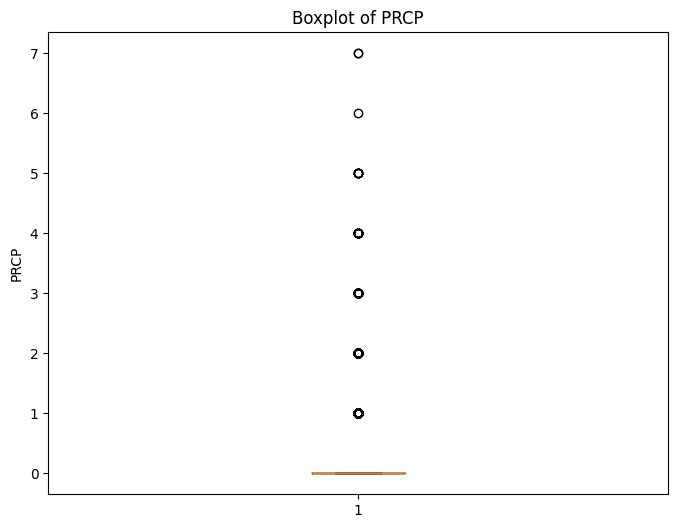

In [24]:
plt.figure(figsize=(8, 6))
plt.boxplot(pt_data['PRCP'])

# Add title and labels
plt.title('Boxplot of PRCP')
plt.ylabel('PRCP')

# Show the plot
plt.show()

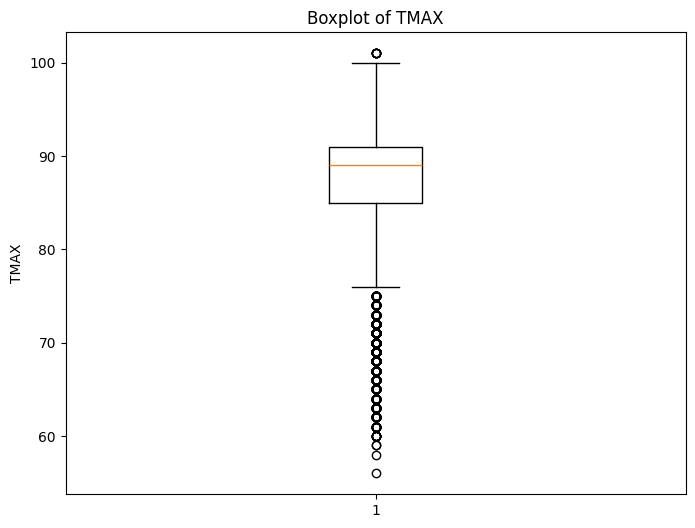

In [25]:
plt.figure(figsize=(8, 6))
plt.boxplot(pt_data['TMAX'])

# Add title and labels
plt.title('Boxplot of TMAX')
plt.ylabel('TMAX')

# Show the plot
plt.show()

In [26]:
# Upper & Lower Bound of the Dataset

# Calculate Q1, Q3, and IQR
Q1 = pt_data['TMAX'].quantile(0.25)
Q3 = pt_data['TMAX'].quantile(0.75)
IQR = Q3 - Q1

# Compute upper whisker value
upper_whisker = Q3 + 1.5 * IQR
lower_whisker = Q3 - 1.5 * IQR

# Find the highest data point within the upper whisker range
upper_bound_data = pt_data['TMAX'][pt_data['TMAX'] <= upper_whisker].max()
lower_bound_data = pt_data['TMAX'][pt_data['TMAX'] <= lower_whisker].max()

print("Upper bound within the boxplot:", upper_bound_data)
print("Lower bound within the boxplot:", lower_bound_data)

# Number of records upper the bound of the dataset
HCHO_Reading_outliers_max = pt_data[pt_data['TMAX'] >= 100].value_counts().sum()
HCHO_Reading_outliers_min = pt_data[pt_data['TMAX'] <= 82].value_counts().sum()
print(f'Number of outliers above:- {HCHO_Reading_outliers_max}')
print(f'Number of outliers below:- {HCHO_Reading_outliers_min}')

Upper bound within the boxplot: 100
Lower bound within the boxplot: 82
Number of outliers above:- 18
Number of outliers below:- 1773


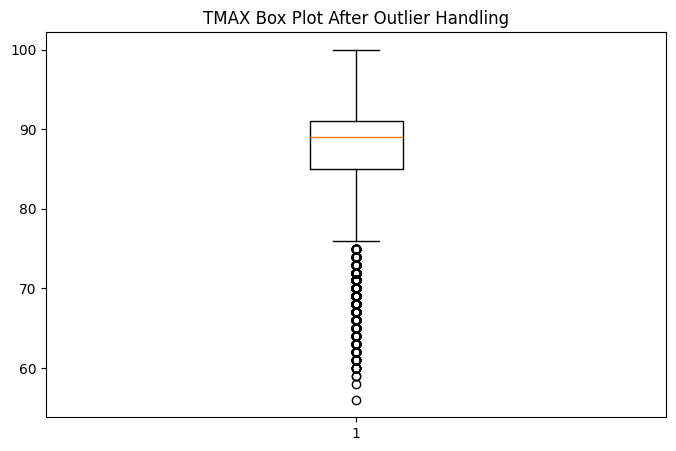

In [27]:
# Handle outliers by replacing values above 100 with the mean of values below 100
mean_tmax = pt_data.loc[pt_data["TMAX"] < 100, "TMAX"].mean()
pt_data.loc[pt_data["TMAX"] > 100, "TMAX"] = mean_tmax

# Create a box plot for the "TMAX" column after handling outliers
plt.figure(figsize=(8, 5))
plt.boxplot(x=pt_data["TMAX"])
plt.title("TMAX Box Plot After Outlier Handling")
plt.show()

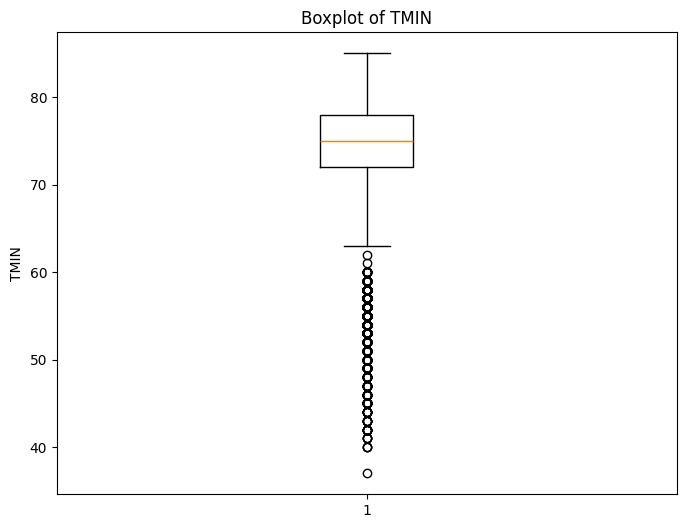

In [28]:
plt.figure(figsize=(8, 6))
plt.boxplot(pt_data['TMIN'])

# Add title and labels
plt.title('Boxplot of TMIN')
plt.ylabel('TMIN')

# Show the plot
plt.show()

In [29]:
# Upper & Lower Bound of the Dataset

# Calculate Q1, Q3, and IQR
Q1 = pt_data['TMIN'].quantile(0.25)
Q3 = pt_data['TMIN'].quantile(0.75)
IQR = Q3 - Q1

# Compute upper whisker value
upper_whisker = Q3 + 1.5 * IQR
lower_whisker = Q3 - 1.5 * IQR

# Find the highest data point within the upper whisker range
upper_bound_data = pt_data['TMIN'][pt_data['TMIN'] <= upper_whisker].max()
lower_bound_data = pt_data['TMIN'][pt_data['TMIN'] <= lower_whisker].max()

print("Upper bound within the boxplot:", upper_bound_data)
print("Lower bound within the boxplot:", lower_bound_data)

# Number of records upper the bound of the dataset
HCHO_Reading_outliers_max = pt_data[pt_data['TMIN'] >= 85].value_counts().sum()
HCHO_Reading_outliers_min = pt_data[pt_data['TMIN'] <= 69].value_counts().sum()
print(f'Number of outliers above:- {HCHO_Reading_outliers_max}')
print(f'Number of outliers below:- {HCHO_Reading_outliers_min}')

Upper bound within the boxplot: 85
Lower bound within the boxplot: 69
Number of outliers above:- 2
Number of outliers below:- 1901


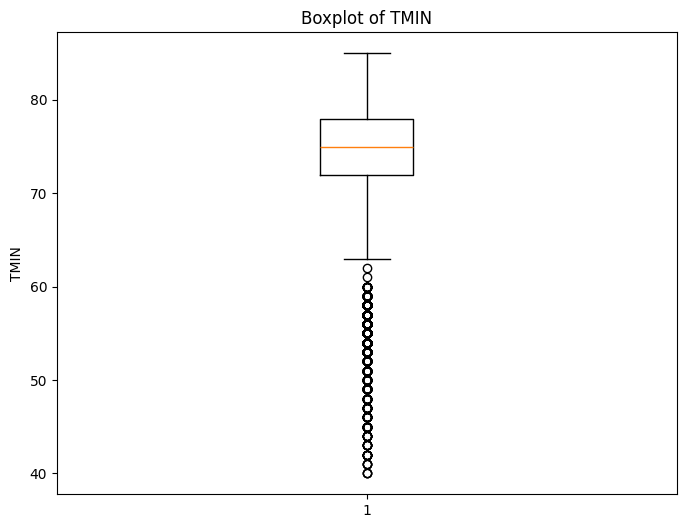

In [30]:
filtered_data = pt_data[pt_data['TMIN'] >= 40]

plt.figure(figsize=(8, 6))
plt.boxplot(filtered_data['TMIN'])

# Add title and labels
plt.title('Boxplot of TMIN')
plt.ylabel('TMIN')

# Show the plot
plt.show()

In [31]:
pt_data.to_csv("preprocessed_dataset/pt_data.csv", index=False)

### JOINING 

In [32]:
# Load the dataset
hcho_data = spark.read.csv("preprocessed_dataset/hcho_data.csv", header=True, inferSchema=True)
hcho_data.show()

+--------------------+-------------------+------------+----------+
|        HCHO Reading|           Location|Current Date| Next Date|
+--------------------+-------------------+------------+----------+
|1.969834395781014...|     Colombo Proper|  2019-01-01|2019-01-02|
|1.969834395781014...|   Deniyaya, Matara|  2019-01-01|2019-01-02|
|2.625522171968594...|Nuwara Eliya Proper|  2019-01-01|2019-01-02|
|2.625522171968594...|     Colombo Proper|  2019-01-02|2019-01-03|
|5.803530712000793E-6|   Deniyaya, Matara|  2019-01-02|2019-01-03|
|5.803530712000793E-6|Nuwara Eliya Proper|  2019-01-02|2019-01-03|
|9.852118897938794E-5|     Colombo Proper|  2019-01-03|2019-01-04|
|2.362357772653922...|   Deniyaya, Matara|  2019-01-03|2019-01-04|
|1.908293886956784...|Nuwara Eliya Proper|  2019-01-03|2019-01-04|
|2.099320518114242E-4|     Colombo Proper|  2019-01-04|2019-01-05|
|6.437245753953118E-5|   Deniyaya, Matara|  2019-01-04|2019-01-05|
|5.097625917127737...|Nuwara Eliya Proper|  2019-01-04|2019-01

In [33]:
# Load the dataset
pt_data = spark.read.csv("preprocessed_dataset/pt_data.csv", header=True, inferSchema=True)
pt_data.show()

+-----------+----------------+--------+---------+---------+----------+----+----+----+----+
|    STATION|            NAME|LATITUDE|LONGITUDE|ELEVATION|      DATE|PRCP|TAVG|TMAX|TMIN|
+-----------+----------------+--------+---------+---------+----------+----+----+----+----+
|CEM00043418|   CHINA BAY, CE|   8.539|   81.182|      1.8|2019-01-01|   0|  79|82.0|  76|
|CEM00043466|     COLOMBO, CE|     6.9|   79.867|      7.0|2019-01-01|   0|  81|89.0|  74|
|CE000434730|NUWARA ELIYA, CE|   6.967|   80.767|   1880.0|2019-01-01|   0|  61|71.0|  49|
|CEM00043424|    PUTTALAM, CE|   8.033|   79.833|      2.0|2019-01-01|   0|  78|87.0|  49|
|CEM00043441|  KURUNEGALA, CE|   7.467|   80.367|    116.0|2019-01-02|   0|  78|87.0|  72|
|CEM00043418|   CHINA BAY, CE|   8.539|   81.182|      1.8|2019-01-02|   0|  78|87.0|  76|
|CEM00043466|     COLOMBO, CE|     6.9|   79.867|      7.0|2019-01-02|   0|  78|87.0|  74|
|CE000434730|NUWARA ELIYA, CE|   6.967|   80.767|   1880.0|2019-01-02|   0|  59|87.0|  49|

In [34]:
filtered_hcho_data = hcho_data.filter(
    (hcho_data.Location == "Colombo Proper") | 
    (hcho_data.Location == "Nuwara Eliya Proper") |
    (hcho_data.Location == "Kurunegala Proper")
)
filtered_hcho_data.show()

+--------------------+-------------------+------------+----------+
|        HCHO Reading|           Location|Current Date| Next Date|
+--------------------+-------------------+------------+----------+
|1.969834395781014...|     Colombo Proper|  2019-01-01|2019-01-02|
|2.625522171968594...|Nuwara Eliya Proper|  2019-01-01|2019-01-02|
|2.625522171968594...|     Colombo Proper|  2019-01-02|2019-01-03|
|5.803530712000793E-6|Nuwara Eliya Proper|  2019-01-02|2019-01-03|
|9.852118897938794E-5|     Colombo Proper|  2019-01-03|2019-01-04|
|1.908293886956784...|Nuwara Eliya Proper|  2019-01-03|2019-01-04|
|2.099320518114242E-4|     Colombo Proper|  2019-01-04|2019-01-05|
|5.097625917127737...|Nuwara Eliya Proper|  2019-01-04|2019-01-05|
|1.785337298892930...|     Colombo Proper|  2019-01-05|2019-01-06|
|6.456645496655256E-5|Nuwara Eliya Proper|  2019-01-05|2019-01-06|
|1.082296700235670...|     Colombo Proper|  2019-01-06|2019-01-07|
|8.982348709518115E-5|Nuwara Eliya Proper|  2019-01-06|2019-01

In [35]:
filtered_pt_data = pt_data.filter(
    (pt_data.NAME == "COLOMBO, CE") | 
    (pt_data.NAME == "NUWARA ELIYA, CE") |
    (pt_data.NAME == "KURUNEGALA, CE")
)
filtered_pt_data.show()

+-----------+----------------+--------+---------+---------+----------+----+----+----+----+
|    STATION|            NAME|LATITUDE|LONGITUDE|ELEVATION|      DATE|PRCP|TAVG|TMAX|TMIN|
+-----------+----------------+--------+---------+---------+----------+----+----+----+----+
|CEM00043466|     COLOMBO, CE|     6.9|   79.867|      7.0|2019-01-01|   0|  81|89.0|  74|
|CE000434730|NUWARA ELIYA, CE|   6.967|   80.767|   1880.0|2019-01-01|   0|  61|71.0|  49|
|CEM00043441|  KURUNEGALA, CE|   7.467|   80.367|    116.0|2019-01-02|   0|  78|87.0|  72|
|CEM00043466|     COLOMBO, CE|     6.9|   79.867|      7.0|2019-01-02|   0|  78|87.0|  74|
|CE000434730|NUWARA ELIYA, CE|   6.967|   80.767|   1880.0|2019-01-02|   0|  59|87.0|  49|
|CEM00043441|  KURUNEGALA, CE|   7.467|   80.367|    116.0|2019-01-03|   0|  81|87.0|  71|
|CEM00043466|     COLOMBO, CE|     6.9|   79.867|      7.0|2019-01-03|   0|  81|90.0|  74|
|CE000434730|NUWARA ELIYA, CE|   6.967|   80.767|   1880.0|2019-01-03|   0|  59|71.0|  49|

In [36]:
# Changing the Location into Capital and to match the Names in Precipitation data 
filtered_hcho_data = filtered_hcho_data.withColumn(
    "New_Location",
    when(filtered_hcho_data.Location == "Colombo Proper", "COLOMBO, CE")
    .when(filtered_hcho_data.Location == "Nuwara Eliya Proper", "NUWARA ELIYA, CE")
    .when(filtered_hcho_data.Location == "Kurunegala Proper", "KURUNEGALA, CE")
    .otherwise(filtered_hcho_data.Location)
)
filtered_hcho_data.show()

+--------------------+-------------------+------------+----------+----------------+
|        HCHO Reading|           Location|Current Date| Next Date|    New_Location|
+--------------------+-------------------+------------+----------+----------------+
|1.969834395781014...|     Colombo Proper|  2019-01-01|2019-01-02|     COLOMBO, CE|
|2.625522171968594...|Nuwara Eliya Proper|  2019-01-01|2019-01-02|NUWARA ELIYA, CE|
|2.625522171968594...|     Colombo Proper|  2019-01-02|2019-01-03|     COLOMBO, CE|
|5.803530712000793E-6|Nuwara Eliya Proper|  2019-01-02|2019-01-03|NUWARA ELIYA, CE|
|9.852118897938794E-5|     Colombo Proper|  2019-01-03|2019-01-04|     COLOMBO, CE|
|1.908293886956784...|Nuwara Eliya Proper|  2019-01-03|2019-01-04|NUWARA ELIYA, CE|
|2.099320518114242E-4|     Colombo Proper|  2019-01-04|2019-01-05|     COLOMBO, CE|
|5.097625917127737...|Nuwara Eliya Proper|  2019-01-04|2019-01-05|NUWARA ELIYA, CE|
|1.785337298892930...|     Colombo Proper|  2019-01-05|2019-01-06|     COLOM

In [37]:
# Renaming the "Current Date" column for the easy use of joining 
filtered_hcho_data = filtered_hcho_data.withColumnRenamed("Current Date", "Current_Date")
filtered_hcho_data = filtered_hcho_data.withColumnRenamed("HCHO Reading", "HCHO_Reading")
filtered_hcho_data = filtered_hcho_data.withColumnRenamed("Next Date", "Next_Date")
filtered_hcho_data.show()

+--------------------+-------------------+------------+----------+----------------+
|        HCHO_Reading|           Location|Current_Date| Next_Date|    New_Location|
+--------------------+-------------------+------------+----------+----------------+
|1.969834395781014...|     Colombo Proper|  2019-01-01|2019-01-02|     COLOMBO, CE|
|2.625522171968594...|Nuwara Eliya Proper|  2019-01-01|2019-01-02|NUWARA ELIYA, CE|
|2.625522171968594...|     Colombo Proper|  2019-01-02|2019-01-03|     COLOMBO, CE|
|5.803530712000793E-6|Nuwara Eliya Proper|  2019-01-02|2019-01-03|NUWARA ELIYA, CE|
|9.852118897938794E-5|     Colombo Proper|  2019-01-03|2019-01-04|     COLOMBO, CE|
|1.908293886956784...|Nuwara Eliya Proper|  2019-01-03|2019-01-04|NUWARA ELIYA, CE|
|2.099320518114242E-4|     Colombo Proper|  2019-01-04|2019-01-05|     COLOMBO, CE|
|5.097625917127737...|Nuwara Eliya Proper|  2019-01-04|2019-01-05|NUWARA ELIYA, CE|
|1.785337298892930...|     Colombo Proper|  2019-01-05|2019-01-06|     COLOM

In [38]:
dataset_length1 = filtered_hcho_data.count()
print("The length of the 'hcho_data' dataset is:", dataset_length1)
dataset_length = filtered_pt_data.count()
print("The length of the 'pt_data' dataset is:", dataset_length)

The length of the 'hcho_data' dataset is: 5478
The length of the 'pt_data' dataset is: 5230


In [39]:
joined_data = filtered_hcho_data.join(
    filtered_pt_data,
    (filtered_hcho_data.New_Location == filtered_pt_data.NAME) & (filtered_hcho_data.Current_Date == filtered_pt_data.DATE),
    'inner'  
)
joined_data.show()

+--------------------+-------------------+------------+----------+----------------+-----------+----------------+--------+---------+---------+----------+----+----+----+----+
|        HCHO_Reading|           Location|Current_Date| Next_Date|    New_Location|    STATION|            NAME|LATITUDE|LONGITUDE|ELEVATION|      DATE|PRCP|TAVG|TMAX|TMIN|
+--------------------+-------------------+------------+----------+----------------+-----------+----------------+--------+---------+---------+----------+----+----+----+----+
|1.969834395781014...|     Colombo Proper|  2019-01-01|2019-01-02|     COLOMBO, CE|CEM00043466|     COLOMBO, CE|     6.9|   79.867|      7.0|2019-01-01|   0|  81|89.0|  74|
|2.625522171968594...|Nuwara Eliya Proper|  2019-01-01|2019-01-02|NUWARA ELIYA, CE|CE000434730|NUWARA ELIYA, CE|   6.967|   80.767|   1880.0|2019-01-01|   0|  61|71.0|  49|
|2.625522171968594...|     Colombo Proper|  2019-01-02|2019-01-03|     COLOMBO, CE|CEM00043466|     COLOMBO, CE|     6.9|   79.867|    

In [40]:
dataset_length = joined_data.count()
print("The length of the dataset is:", dataset_length)

The length of the dataset is: 5230


In [41]:
joined_data = joined_data.drop('Location', 'Current_Date', 'NAME')
joined_data.show()

+--------------------+----------+----------------+-----------+--------+---------+---------+----------+----+----+----+----+
|        HCHO_Reading| Next_Date|    New_Location|    STATION|LATITUDE|LONGITUDE|ELEVATION|      DATE|PRCP|TAVG|TMAX|TMIN|
+--------------------+----------+----------------+-----------+--------+---------+---------+----------+----+----+----+----+
|1.969834395781014...|2019-01-02|     COLOMBO, CE|CEM00043466|     6.9|   79.867|      7.0|2019-01-01|   0|  81|89.0|  74|
|2.625522171968594...|2019-01-02|NUWARA ELIYA, CE|CE000434730|   6.967|   80.767|   1880.0|2019-01-01|   0|  61|71.0|  49|
|2.625522171968594...|2019-01-03|     COLOMBO, CE|CEM00043466|     6.9|   79.867|      7.0|2019-01-02|   0|  78|87.0|  74|
|5.803530712000793E-6|2019-01-03|NUWARA ELIYA, CE|CE000434730|   6.967|   80.767|   1880.0|2019-01-02|   0|  59|87.0|  49|
|9.852118897938794E-5|2019-01-04|     COLOMBO, CE|CEM00043466|     6.9|   79.867|      7.0|2019-01-03|   0|  81|90.0|  74|
|1.9082938869567

In [42]:
joined_data = joined_data.toPandas()
joined_data

,HCHO_Reading,Next_Date,New_Location,STATION,LATITUDE,LONGITUDE,ELEVATION,DATE,PRCP,TAVG,TMAX,TMIN
0,0.000197,2019-01-02,"COLOMBO, CE",CEM00043466,6.900,79.867,7.0,2019-01-01,0,81,89.0,74
1,0.000263,2019-01-02,"NUWARA ELIYA, CE",CE000434730,6.967,80.767,1880.0,2019-01-01,0,61,71.0,49
2,0.000263,2019-01-03,"COLOMBO, CE",CEM00043466,6.900,79.867,7.0,2019-01-02,0,78,87.0,74
3,0.000006,2019-01-03,"NUWARA ELIYA, CE",CE000434730,6.967,80.767,1880.0,2019-01-02,0,59,87.0,49
4,0.000099,2019-01-04,"COLOMBO, CE",CEM00043466,6.900,79.867,7.0,2019-01-03,0,81,90.0,74
...,...,...,...,...,...,...,...,...,...,...,...,...
5225,0.000075,2023-12-28,"KURUNEGALA, CE",CEM00043441,7.467,80.367,116.0,2023-12-27,0,81,88.0,76
5226,0.000051,2023-12-29,"KURUNEGALA, CE",CEM00043441,7.467,80.367,116.0,2023-12-28,0,79,83.0,76
5227,0.000127,2023-12-30,"KURUNEGALA, CE",CEM00043441,7.467,80.367,116.0,2023-12-29,0,77,82.0,75
5228,0.000158,2023-12-31,"KURUNEGALA, CE",CEM00043441,7.467,80.367,116.0,2023-12-30,0,80,87.0,74


### VISUALIZATION

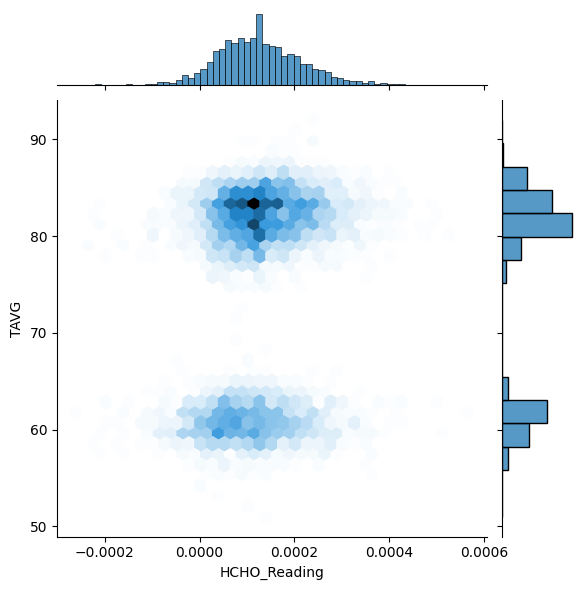

In [44]:
sns.jointplot(x ="HCHO_Reading", y="TAVG", data=joined_data, kind="hex")

<Axes: xlabel='HCHO_Reading', ylabel='TMAX'>

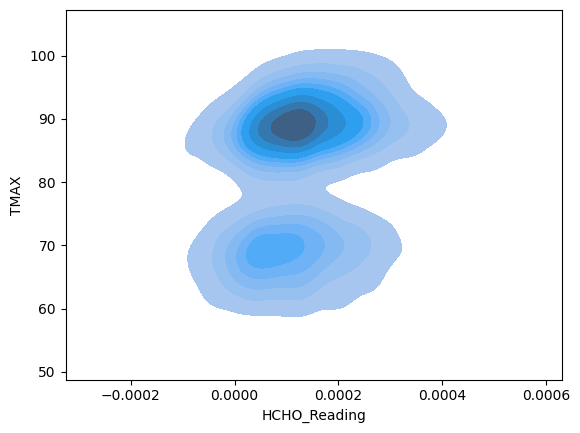

In [45]:
sns.kdeplot(data=joined_data, x="HCHO_Reading", y="TMAX", fill=True)

<Axes: xlabel='ELEVATION', ylabel='HCHO_Reading'>

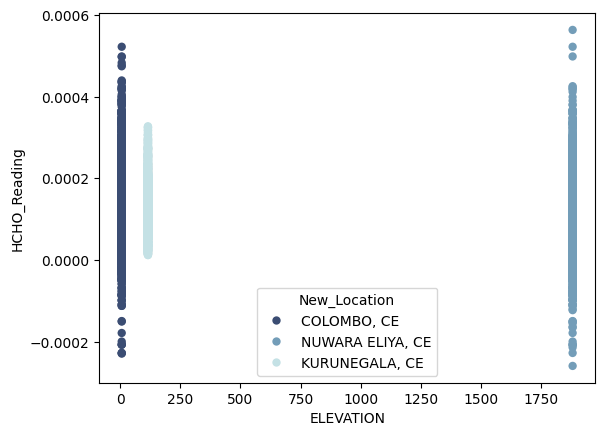

In [58]:
sns.scatterplot(x="ELEVATION", y="HCHO_Reading",
                hue="New_Location",
                palette="ch:r=-.2,d=.3_r",
                sizes=(3, 9), linewidth=0,
                data=joined_data)

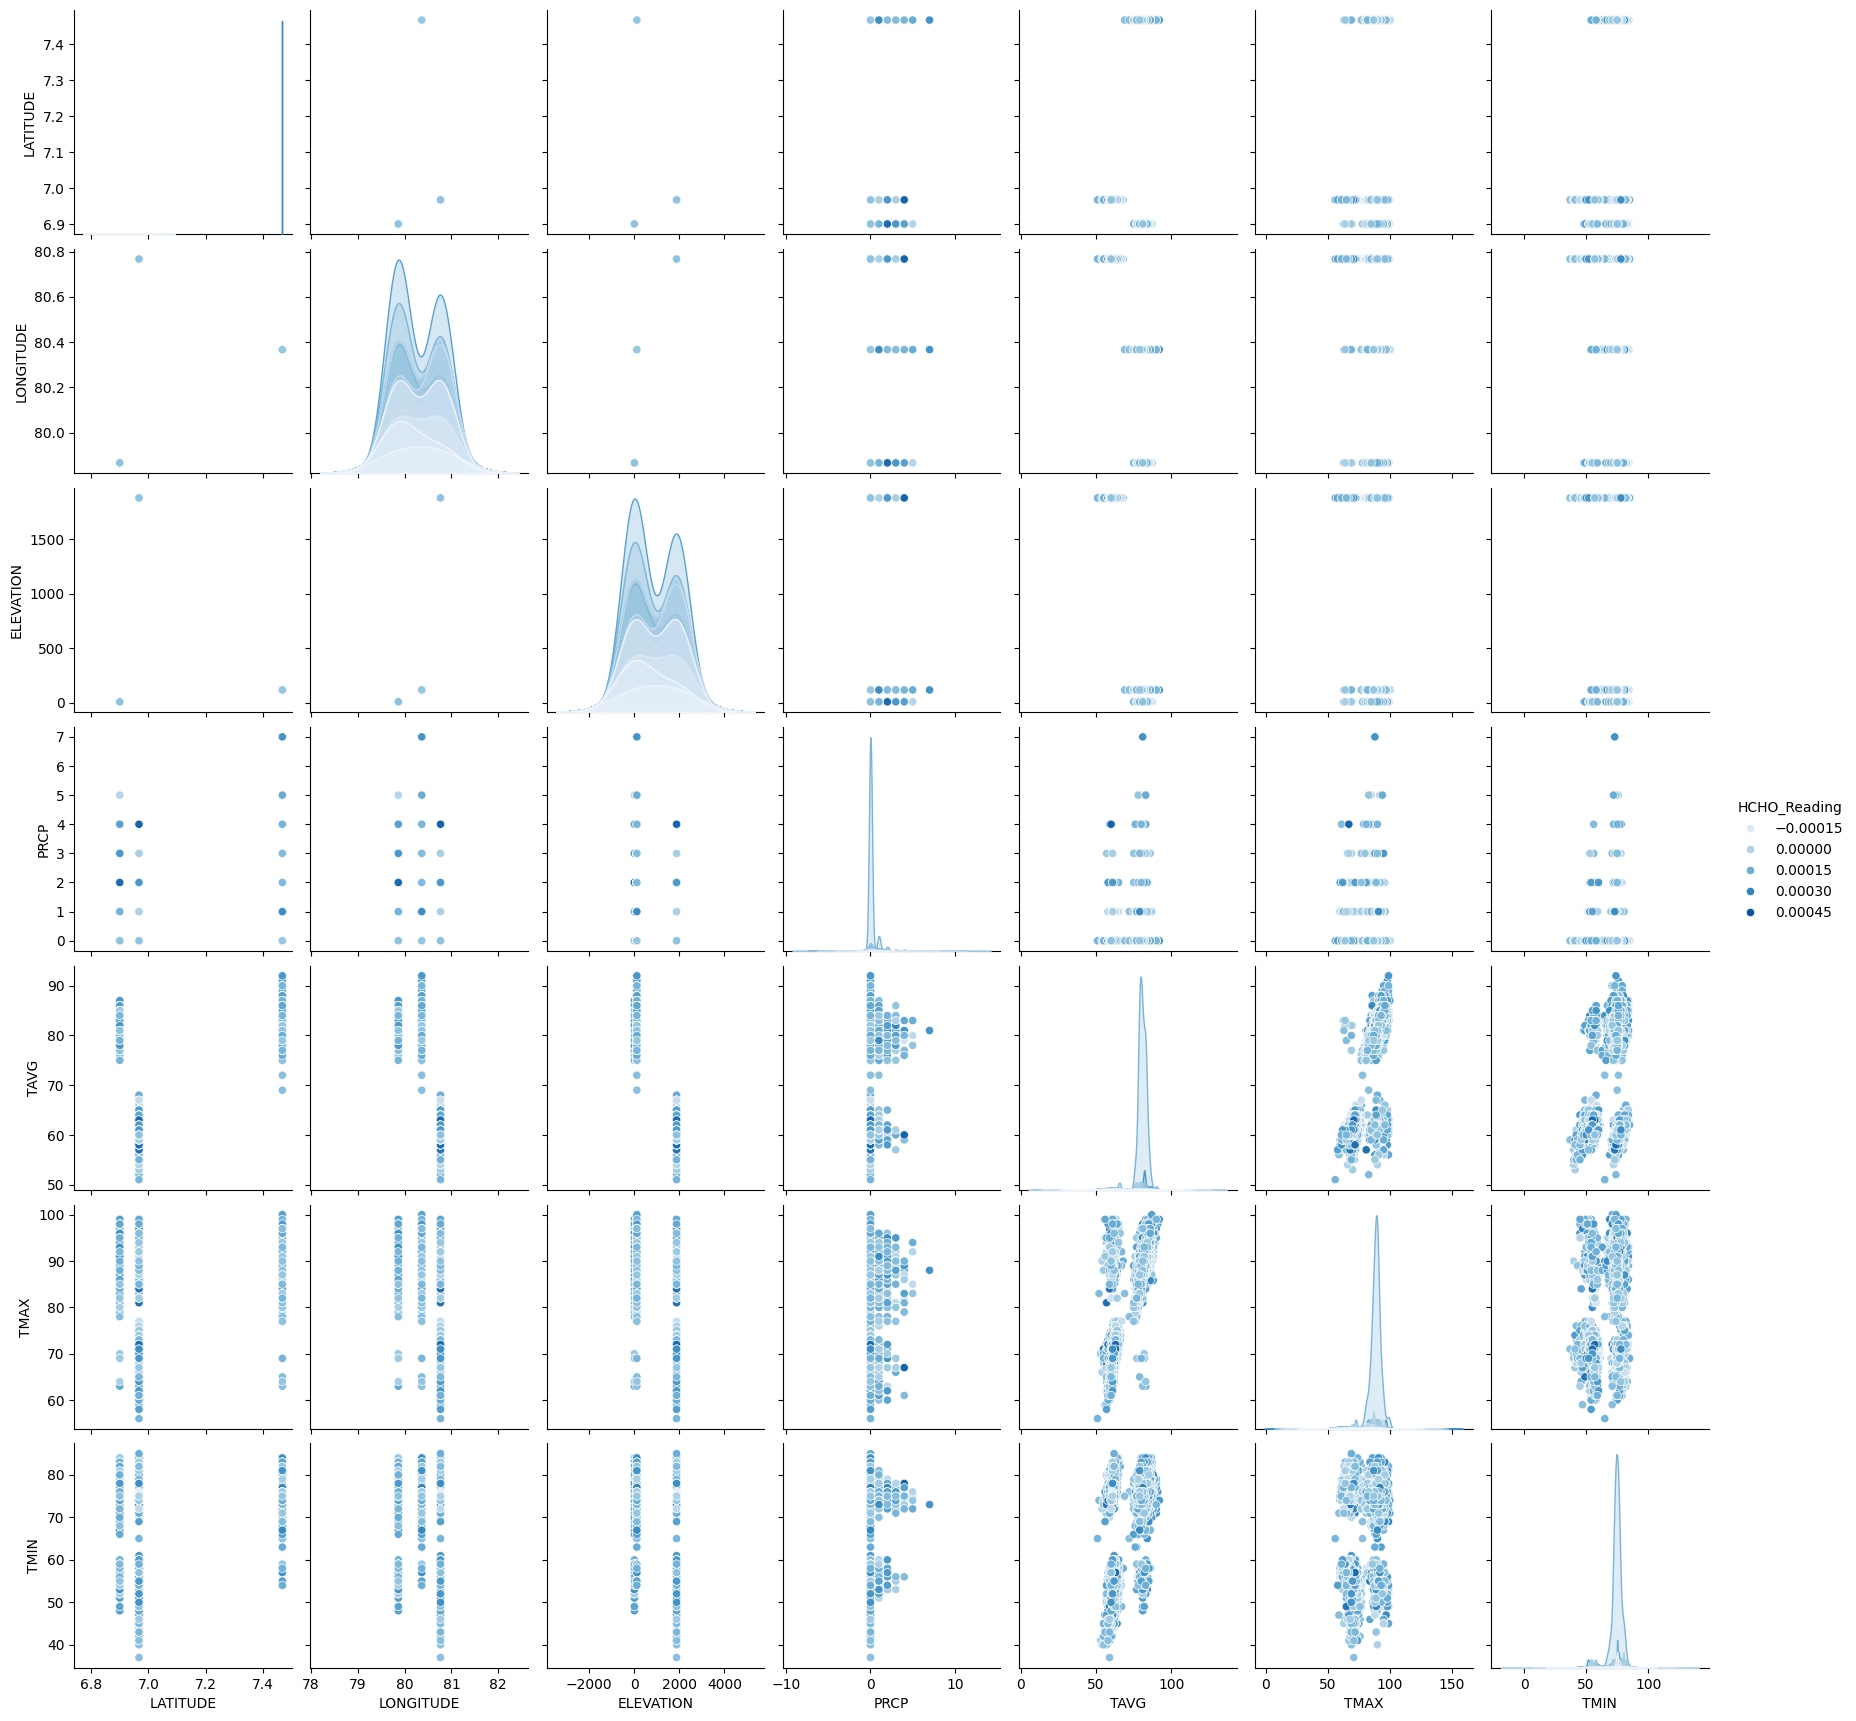

In [47]:
sns.pairplot(hue ="HCHO_Reading", data=joined_data, palette="Blues")

In [48]:
joined_data.to_csv("preprocessed_dataset/joined_data.csv", index=False)

In [49]:
# Reading the preprocessed dataset 
joined_data = pd.read_csv("preprocessed_dataset/joined_data.csv")
joined_data

,HCHO_Reading,Next_Date,New_Location,STATION,LATITUDE,LONGITUDE,ELEVATION,DATE,PRCP,TAVG,TMAX,TMIN
0,0.000197,2019-01-02,"COLOMBO, CE",CEM00043466,6.900,79.867,7.0,2019-01-01,0,81,89.0,74
1,0.000263,2019-01-02,"NUWARA ELIYA, CE",CE000434730,6.967,80.767,1880.0,2019-01-01,0,61,71.0,49
2,0.000263,2019-01-03,"COLOMBO, CE",CEM00043466,6.900,79.867,7.0,2019-01-02,0,78,87.0,74
3,0.000006,2019-01-03,"NUWARA ELIYA, CE",CE000434730,6.967,80.767,1880.0,2019-01-02,0,59,87.0,49
4,0.000099,2019-01-04,"COLOMBO, CE",CEM00043466,6.900,79.867,7.0,2019-01-03,0,81,90.0,74
...,...,...,...,...,...,...,...,...,...,...,...,...
5225,0.000075,2023-12-28,"KURUNEGALA, CE",CEM00043441,7.467,80.367,116.0,2023-12-27,0,81,88.0,76
5226,0.000051,2023-12-29,"KURUNEGALA, CE",CEM00043441,7.467,80.367,116.0,2023-12-28,0,79,83.0,76
5227,0.000127,2023-12-30,"KURUNEGALA, CE",CEM00043441,7.467,80.367,116.0,2023-12-29,0,77,82.0,75
5228,0.000158,2023-12-31,"KURUNEGALA, CE",CEM00043441,7.467,80.367,116.0,2023-12-30,0,80,87.0,74


In [50]:
# Take the absolute value of HCHO_Reading for visualization purposes
joined_data['HCHO_Reading_Abs'] = joined_data['HCHO_Reading'].abs()

# Define constants for visual properties
FONT_COLOR = '#FFFFFF'
BACKGROUND_COLOR = '#000000'

# Plot the data collection locations
fig = px.scatter_mapbox(
    joined_data,
    lat="LATITUDE",
    lon="LONGITUDE",
    size='HCHO_Reading_Abs',  # Use the absolute values for sizing
    color='HCHO_Reading',
    color_continuous_scale=px.colors.sequential.Viridis,
    size_max=20,
    zoom=5,
    width=840,
    height=840,
    title="Data Collection Locations<br>"
          "<span style='font-size: 75%; font-weight: bold;'>"
          "HCHO Readings</span>"
)

# Update the rest of the layout
fig.update_layout(
    mapbox_style="open-street-map",
    margin=dict(r=0, t=90, l=0, b=0),
    font_color=FONT_COLOR,
    title_font_size=18,
    legend=dict(yanchor="bottom", xanchor="right", y=1, x=1, orientation="h"),
    plot_bgcolor=BACKGROUND_COLOR,
    paper_bgcolor=BACKGROUND_COLOR,
)

fig.show()

In [51]:
import pandas as pd
import plotly.express as px

# Define constants for visual properties
FONT_COLOR = '#FFFFFF'
BACKGROUND_COLOR = '#000000'

# Plot the data collection locations
fig = px.scatter_mapbox(
    joined_data,
    lat="LATITUDE",
    lon="LONGITUDE",
    size='TAVG', 
    color='TAVG',
    color_continuous_scale=px.colors.sequential.Viridis,
    size_max=20,
    zoom=5,
    width=840,
    height=840,
    title="Data Collection Locations<br>"
          "<span style='font-size: 75%; font-weight: bold;'>"
          "Average Temperature</span>"
)

# Update the rest of the layout
fig.update_layout(
    mapbox_style="open-street-map",
    margin=dict(r=0, t=90, l=0, b=0),
    font_color=FONT_COLOR,
    title_font_size=18,
    legend=dict(yanchor="bottom", xanchor="right", y=1, x=1, orientation="h"),
    plot_bgcolor=BACKGROUND_COLOR,
    paper_bgcolor=BACKGROUND_COLOR,
)

fig.show()

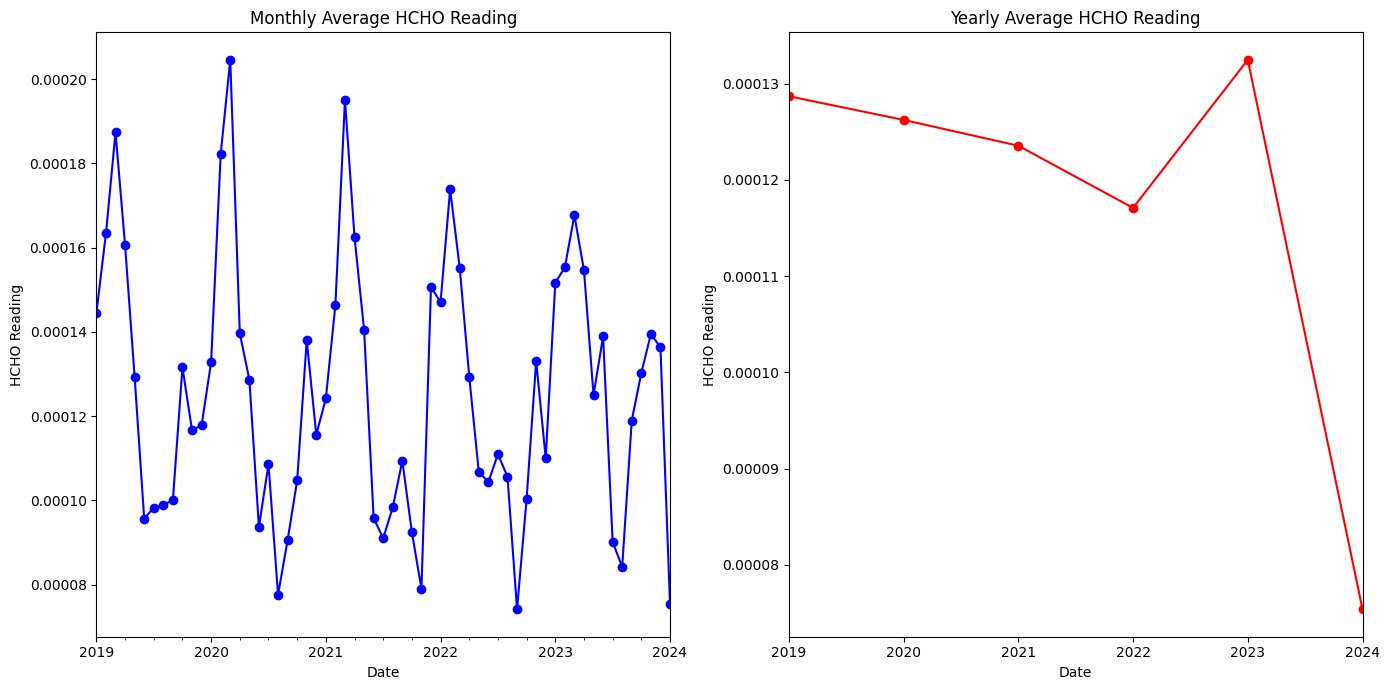

In [52]:
# Ensure the 'Next Date' column is in datetime format and set it as the index
joined_data['Next_Date'] = pd.to_datetime(joined_data['Next_Date'])
joined_data.set_index('Next_Date', inplace=True)

# Select only the numeric columns for resampling
numeric_columns = joined_data.select_dtypes(include='number')

# Now, resample the numeric columns of the DataFrame by month for seasonal analysis
monthly_means = numeric_columns.resample('M').mean()

# Resample the numeric columns of the DataFrame by year for long-term trend analysis
yearly_means = numeric_columns.resample('A').mean()

# Plotting the monthly and yearly average HCHO Reading
plt.figure(figsize=(14, 7))

# Monthly trend
plt.subplot(1, 2, 1)
monthly_means['HCHO_Reading'].plot(title='Monthly Average HCHO Reading', marker='o', color='blue')
plt.xlabel('Date')
plt.ylabel('HCHO Reading')

# Yearly trend
plt.subplot(1, 2, 2)
yearly_means['HCHO_Reading'].plot(title='Yearly Average HCHO Reading', marker='o', color='red')
plt.xlabel('Date')
plt.ylabel('HCHO Reading')

plt.tight_layout()
plt.show()

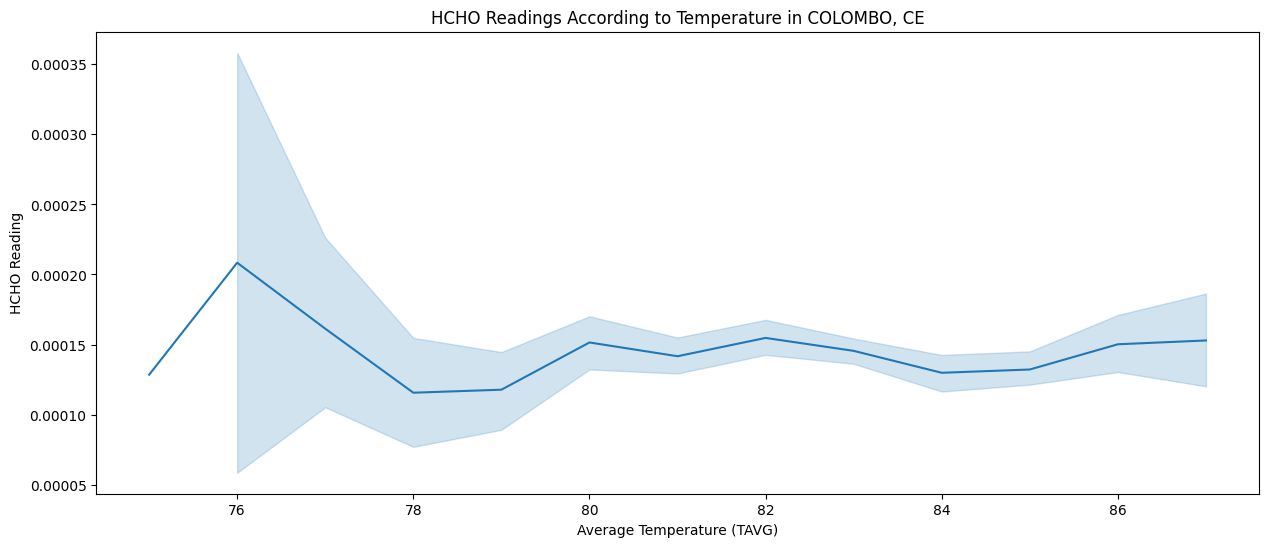

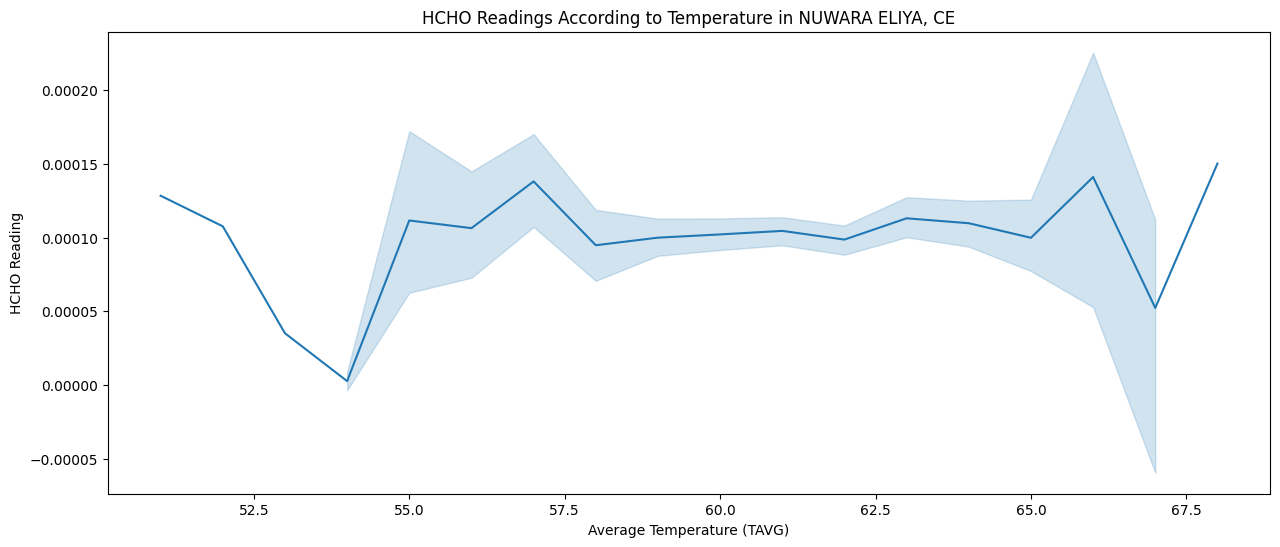

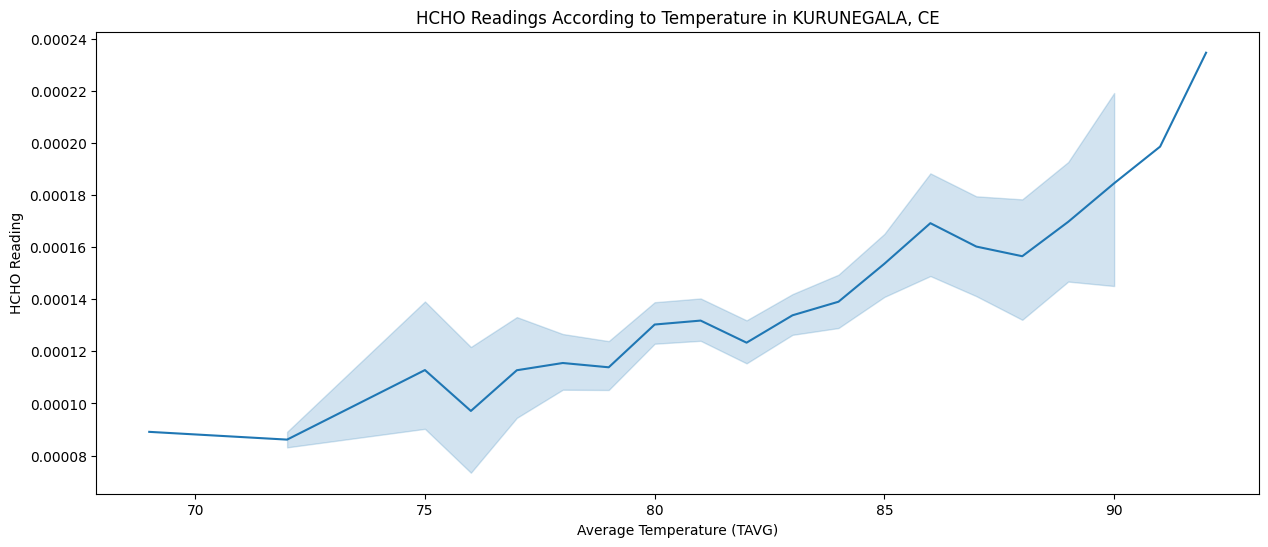

In [53]:
# Loop through each unique city in the data
for city in joined_data['New_Location'].unique():
    # Filter the data for the current city
    city_data = joined_data[joined_data['New_Location'] == city]
    
    # Plotting the trend of HCHO readings according to temperature for the current city
    plt.figure(figsize=(15, 6))
    sns.lineplot(x='TAVG', y='HCHO_Reading', data=city_data)
    
    # Add title, labels, and rotation to x-axis ticks
    plt.title(f'HCHO Readings According to Temperature in {city}')
    plt.xlabel('Average Temperature (TAVG)')
    plt.ylabel('HCHO Reading')
    
    # Show the plot
    plt.show()

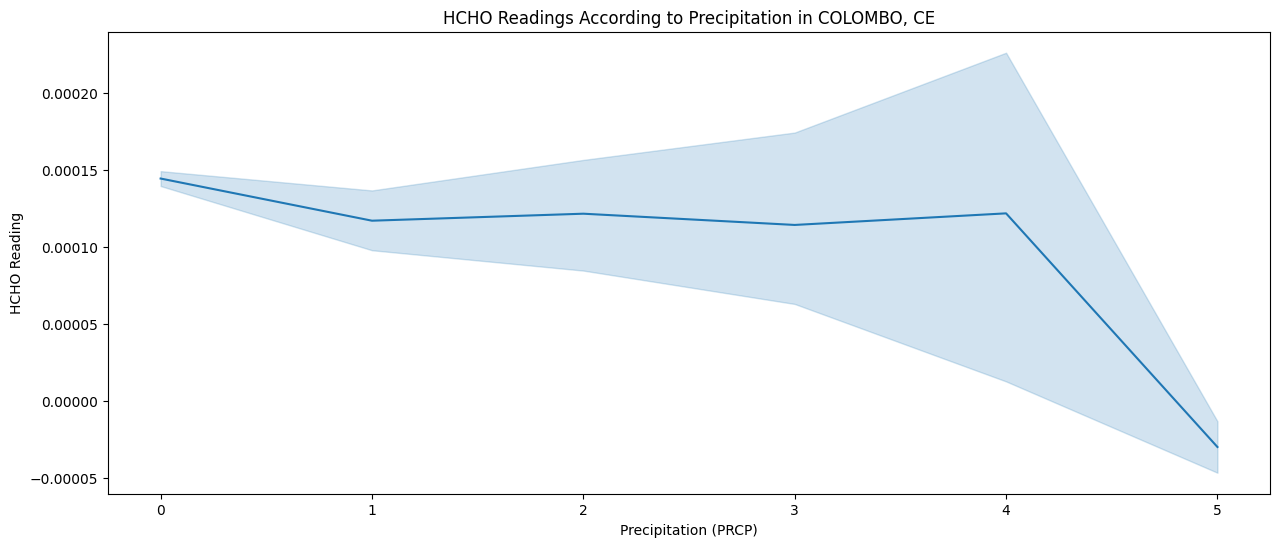

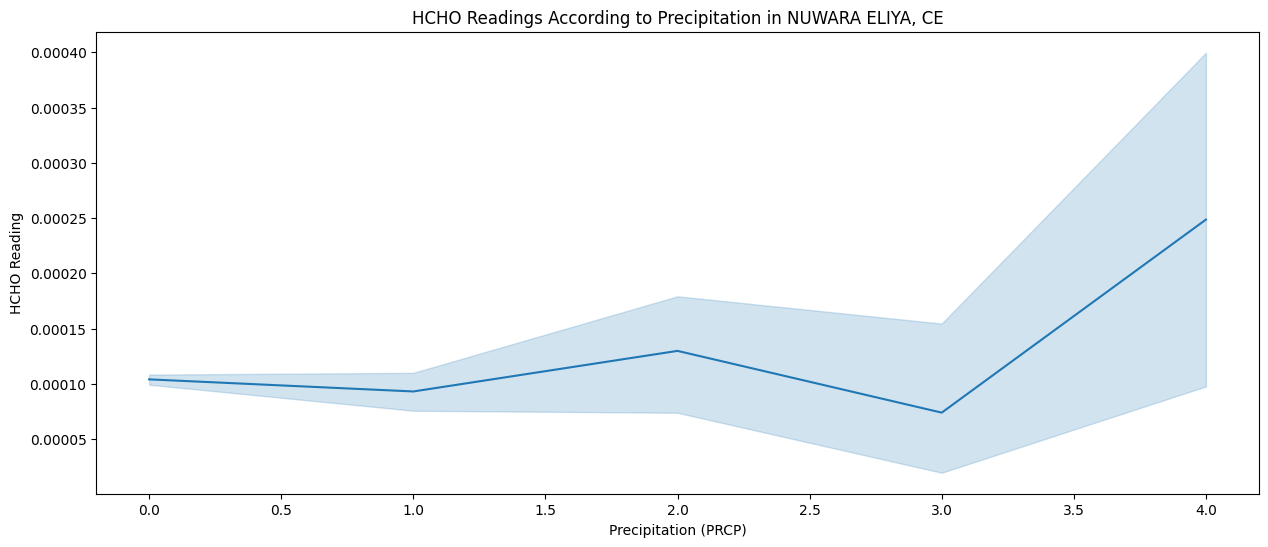

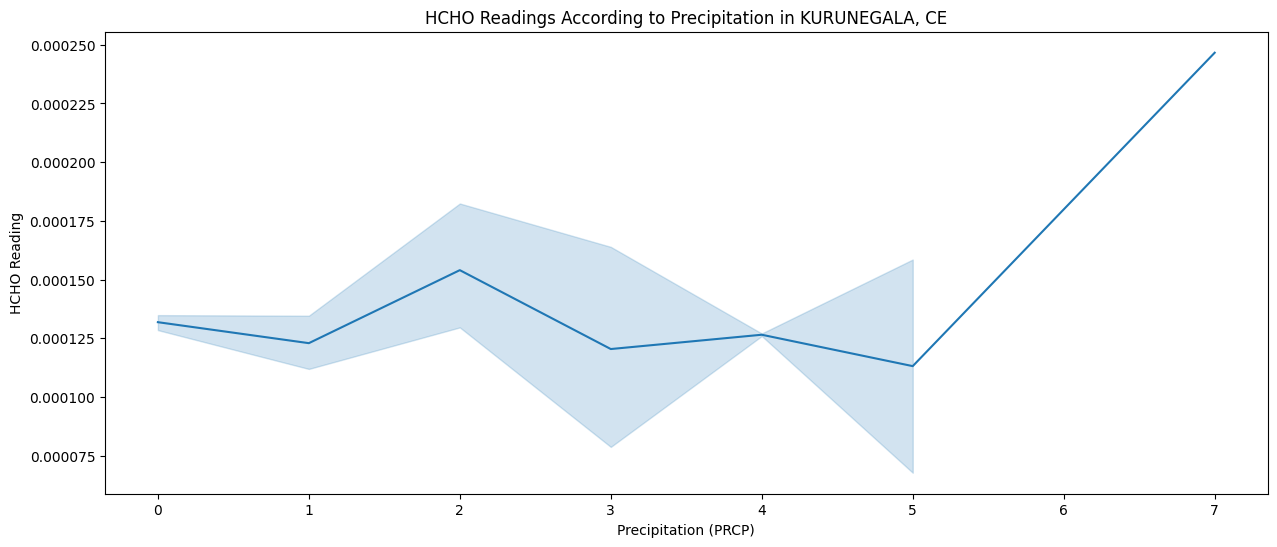

In [55]:
# Loop through each unique city in the data
for city in joined_data['New_Location'].unique():
    # Filter the data for the current city
    city_data = joined_data[joined_data['New_Location'] == city]
    
    # Plotting the trend of HCHO readings according to temperature for the current city
    plt.figure(figsize=(15, 6))
    sns.lineplot(x='PRCP', y='HCHO_Reading', data=city_data)
    
    # Add title, labels, and rotation to x-axis ticks
    plt.title(f'HCHO Readings According to Precipitation in {city}')
    plt.xlabel('Precipitation (PRCP)')
    plt.ylabel('HCHO Reading')
    
    # Show the plot
    plt.show()

Correlation between HCHO Reading and TAVG: 0.18182236702372437
Correlation between HCHO Reading and PRCP: -0.017853009712447646


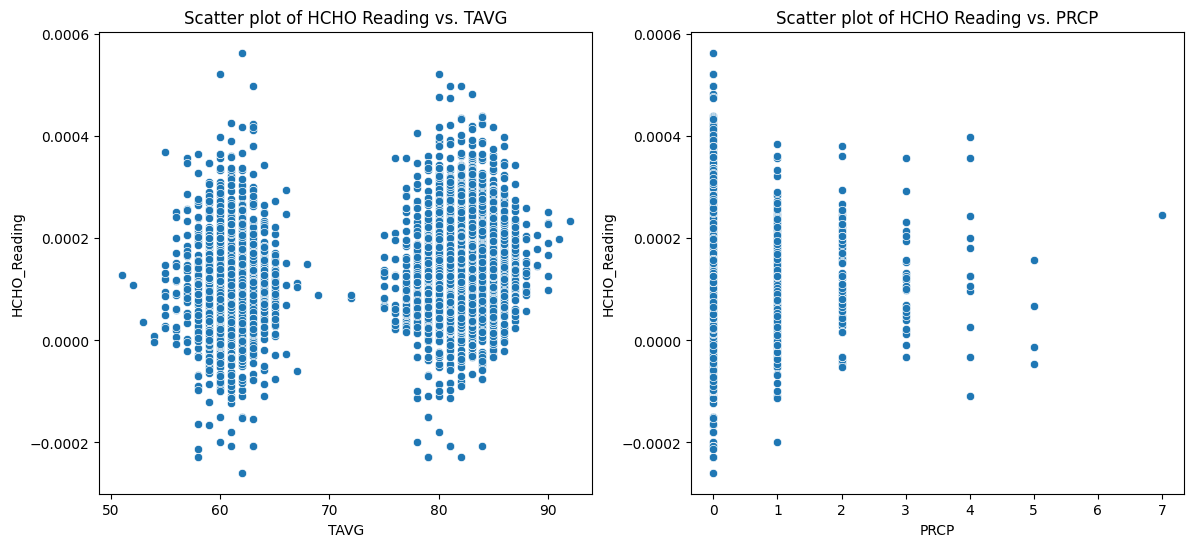

In [54]:
# Calculate Pearson correlation coefficient
correlation_temp = joined_data['HCHO_Reading'].corr(joined_data['TAVG'])
correlation_precip = joined_data['HCHO_Reading'].corr(joined_data['PRCP'])

print(f"Correlation between HCHO Reading and TAVG: {correlation_temp}")
print(f"Correlation between HCHO Reading and PRCP: {correlation_precip}")

# Create scatter plots
plt.figure(figsize=(14, 6))

# Scatter plot for HCHO_Reading and TAVG
plt.subplot(1, 2, 1)
sns.scatterplot(x='TAVG', y='HCHO_Reading', data=joined_data)
plt.title('Scatter plot of HCHO Reading vs. TAVG')

# Scatter plot for HCHO_Reading and PRCP
plt.subplot(1, 2, 2)
sns.scatterplot(x='PRCP', y='HCHO_Reading', data=joined_data)
plt.title('Scatter plot of HCHO Reading vs. PRCP')

plt.show()

 - **For HCHO Reading and TAVG**: A weak positive correlation suggests that higher temperatures might be associated with higher HCHO readings, but the relationship is not strong. This could be due to various factors influencing HCHO concentrations besides temperature, or it might suggest that the relationship is not purely linear or is influenced by other interacting variables.

 - **For HCHO Reading and PRCP**: The weak negative correlation suggests that there's hardly any linear relationship between HCHO readings and precipitation. This could imply that precipitation does not significantly influence HCHO concentrations, or again, that the relationship is complex and possibly modulated by other factors.